# Translate device time into concert time
and cut signals to concert intervals

Starting with AX3 recordings

## load libraries

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport eq
%aimport qex
%aimport al

In [3]:
%reload_ext autoreload

# load concert times, cue times, and data file locs

In [4]:
Piece_dt = pd.read_csv('./Timing/ConcertDateTimes.csv',index_col = 0)
# convert relevant columsn into datetime
for c in Piece_dt.columns[3:]:
    Piece_dt.loc[:,c] = pd.to_datetime(Piece_dt.loc[:,c]).dt.tz_convert('UTC')
Piece_dt.loc[:5,:]

,Related,Event_Type,Event,RD,C1,C2,C3,C4,C5
0,Init,Stage,Pre-Audio,NaT,NaT,2023-02-16 10:09:21.319000+00:00,NaT,NaT,2023-02-18 14:54:07.681000+00:00
1,Init,Orch,Warmup,2023-02-15 11:00:36.897000+00:00,2023-02-16 08:27:30.042000+00:00,2023-02-16 10:10:21.394000+00:00,2023-02-17 08:29:58.895000+00:00,2023-02-17 10:10:41.889000+00:00,2023-02-18 15:04:03.121000+00:00
2,Init,Orch,Tuning,2023-02-15 11:04:38.152000+00:00,2023-02-16 08:32:17.013000+00:00,2023-02-16 10:15:33.575000+00:00,2023-02-17 08:30:03.068000+00:00,2023-02-17 10:15:37.905000+00:00,2023-02-18 15:06:43.947000+00:00
3,Init,Orch,Synch Taps,2023-02-15 11:05:36.897000+00:00,2023-02-16 08:33:18.524000+00:00,2023-02-16 10:16:22.697000+00:00,2023-02-17 08:30:51.841000+00:00,2023-02-17 10:16:26.888000+00:00,2023-02-18 15:10:29.583000+00:00
4,Init,Applause,Applause for Conductor,2023-02-15 11:05:56.191000+00:00,2023-02-16 08:33:46.816000+00:00,2023-02-16 10:18:24.711000+00:00,2023-02-17 08:32:07.915000+00:00,2023-02-17 10:16:48.817000+00:00,2023-02-18 15:09:59.446000+00:00
5,Saev,Music,Saevarud,2023-02-15 11:06:20.804000+00:00,2023-02-16 08:34:03.424000+00:00,2023-02-16 11:11:01.919000+00:00,2023-02-17 09:25:39.887000+00:00,2023-02-17 10:16:57.035000+00:00,2023-02-18 15:10:44.919000+00:00


In [5]:
Piece_timings = pd.read_csv('./Timing/ctimes.csv')
Piece_timings.iloc[[3,33],:] 

,Event,RD,C1,C2,C3,C4,C5
3,Synch Taps,0.000,0.000,0.00,0.000,0.000,0.000
33,End,3395.694,3756.436,3535.87,3544.558,3512.995,3602.818


In [6]:
synch_times = {'RE_Synch':pd.to_datetime('2023-02-15 10:25:26.573+0000'),
               'RD_Synch':pd.to_datetime('2023-02-15 11:05:36.897+0000'),
               'RD_Reic': pd.to_datetime('2023-02-15 11:16:50.919+0000'),
               'RD_Reic2':pd.to_datetime('2023-02-15 12:02:00.040+0000'),# -2.46
              'C1_Synch':pd.to_datetime('2023-02-16 8:33:18.524+0000'), # +0.2
               'C1_Reic':pd.to_datetime('2023-02-16 08:45:22.446+0000'),# +0.2
               'C2_Synch':pd.to_datetime('2023-02-16 10:16:22.697+0000'),
               'C2_Reic':pd.to_datetime('2023-02-16 10:27:10.927+0000'),
              'C3_Synch':pd.to_datetime('2023-02-17 08:30:51.841000+00:00'),
               'C3_Reic':pd.to_datetime('2023-02-17 08:40:31.007000+00:00'),
               'C4_Synch': pd.to_datetime('2023-02-17 10:16:26.888000+00:00'),#'C4_Synch': pd.to_datetime('2023-02-17 10:16:29.298000+00:00'),
               'C4_Reic':pd.to_datetime('2023-02-17 10:27:20.769000+00:00'),#'C4_Reic':pd.to_datetime('2023-02-17 10:27:23.179000+00:00'),
              'C5_Synch':pd.to_datetime('2023-02-18 15:10:29.583000+00:00'),
               'C5_Reic':pd.to_datetime('2023-02-18 15:22:04.555000+00:00')}

c_types = {'RE_Synch':'taps',
               'RD_Reic': 'claps',
               'RD_Synch':'taps',
               'RD_Reic2':'claps',
           'C1_Reic':'claps',#'RE':pd.to_datetime('2023-02-15 11:25:26.573+0100'),
                 'C2_Reic':'claps', # 97.0 
                 'C1_Synch':'taps',
                 'C2_Synch':'taps',
          'C3_Synch':'taps',
               'C3_Reic': 'claps',
               'C4_Synch':'taps',
               'C4_Reic': 'claps',
          'C5_Synch':'taps',
               'C5_Reic': 'claps',}
cue_files ={'RE_Synch':'./Timing/synch_cue_taps.csv',
               'RD_Reic': './Timing/RD_Reic1.csv',
               'RD_Synch':'./Timing/synch_cue_taps.csv',
               'RD_Reic2':'./Timing/RD_Reic2.csv',
            'C1_Synch':'./Timing/short_taps.csv',
               'C1_Reic': './Timing/C1_reic_claps.csv',
               'C2_Synch':'./Timing/short_taps.csv',
               'C2_Reic':'./Timing/C2_reic_claps.csv',
            'C3_Synch':'./Timing/short_taps.csv',
               'C3_Reic': './Timing/C3_reic_claps.csv',
               'C4_Synch':'./Timing/short_taps.csv',
               'C4_Reic':'./Timing/C4_reic_claps.csv',
           'C5_Synch':'./Timing/short_taps.csv',
               'C5_Reic': './Timing/C5_claps.csv',} 

CueT={} # list of cues to check
# sample rate for comparison between cue template and signal
sf = 100
t_range= [-5,10]
for c in synch_times.keys():
    cue_times = pd.read_csv(cue_files[c],",",header=None)
    if len(cue_times.columns)>3:
        cue_times['S_AudioTime'] = np.round(cue_times[0],3) # reset to 50 hz
        cue_times['event'] = cue_times[1]
        cue_times['CTime'] = cue_times['S_AudioTime']-cue_times.loc[3,'S_AudioTime'] # zero on onset of first synch cue
        peak_times = cue_times.loc[cue_times['event'].str.startswith('Tap'),'CTime']
    else:
        peak_times = list(cue_times[0]-cue_times.loc[0,0])
    
    cue = al.cue_template_make(peak_times,sf,t_range)
    CueT[c] = cue 

In [7]:
Part_Dets = pd.read_csv('../Data/Participant_Metadata.csv', index_col = 0)
AX3_users = Part_Dets.loc[Part_Dets.loc[:,['M_RG','M_RE', 'M_RD', 'M_C1', 'M_C2', 'M_C3', 'M_C4', 'M_C5']].sum(axis=1)>0,['M_RG',
       'M_RE', 'M_RD', 'M_C1', 'M_C2', 'M_C3', 'M_C4', 'M_C5']]
for c in ['M_RG','M_RE', 'M_RD', 'M_C1', 'M_C2', 'M_C3', 'M_C4', 'M_C5']:
    AX3_users.loc[AX3_users.loc[:,c].isna(),c] = 0.0
    AX3_users.loc[:,c] = AX3_users.loc[:,c].astype('int32').astype('str')
AX3_files=pd.read_csv('raw_AX3_filelocs.csv',index_col = 0)

In [8]:
cues_aligned = pd.read_csv('RE_RD_AX3s.csv', index_col = 0)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C1_C2_AX3s.csv', index_col = 0)],axis=1)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C3_C4_AX3s.csv', index_col = 0)],axis=1)
cues_aligned = pd.concat([cues_aligned,pd.read_csv('C5_AX3s.csv', index_col = 0)],axis=1)

for c in cues_aligned.columns:
    cues_aligned[c] = pd.to_datetime(cues_aligned[c])
print(len(cues_aligned))
cues_aligned.columns

13


Index(['RE_Synch', 'RD_Synch', 'RD_Reic', 'RD_Reic2', 'C1_Synch', 'C1_Reic',
       'C2_Synch', 'C2_Reic', 'C3_Synch', 'C3_Reic', 'C4_Synch', 'C4_Reic',
       'C5_Synch', 'C5_Reic'],
      dtype='object')

In [9]:
df = (cues_aligned - synch_times)#.dt.total_seconds() # (cues_aligned[cols[j]] - cues_aligned[cols[i]]).dt.total_seconds()
for c in df.columns:
    df[c] = df[c].dt.total_seconds()
df.median()

RE_Synch   -0.770
RD_Synch   -0.795
RD_Reic    -0.750
RD_Reic2   -0.780
C1_Synch    3.480
C1_Reic     3.450
C2_Synch    3.440
C2_Reic     3.400
C3_Synch    4.080
C3_Reic     4.110
C4_Synch    4.100
C4_Reic     4.080
C5_Synch    5.140
C5_Reic     5.190
dtype: float64

In [10]:
cue_time_map = pd.DataFrame(index = cues_aligned.columns,columns = ['dt_UTC','cTime_s','rTime_s'])
cue_time_map['dt_UTC'] = pd.Series(synch_times)
rec_days = {'Re':['RE_Synch', 'RD_Synch', 'RD_Reic','RD_Reic2'], #, 'RD_Reic2'
            'D1':['C1_Synch', 'C1_Reic','C2_Synch', 'C2_Reic'],
           'D2':['C3_Synch', 'C3_Reic', 'C4_Synch', 'C4_Reic'],
            'D3':['C5_Synch', 'C5_Reic']}
sync_days = {'Re':'RE_Synch',
            'D1':'C1_Synch',
            'D2':'C3_Synch',
            'D3':'C5_Synch'}
rec_con = {'RE':['RE_Synch'],
           'RD':['RD_Synch', 'RD_Reic','RD_Reic2'],#, 'RD_Reic2'
           'C1':['C1_Synch', 'C1_Reic'],
           'C2':['C2_Synch', 'C2_Reic'],
           'C3':['C3_Synch', 'C3_Reic'],
           'C4':[ 'C4_Synch', 'C4_Reic'],
           'C5':['C5_Synch', 'C5_Reic']}
sync_con = {'RG':'RE_Synch',
            'RE':'RE_Synch',
            'RD':'RD_Synch',
            'C1':'C1_Synch',
            'C2':'C2_Synch', 
            'C3':'C3_Synch',
            'C4':'C4_Synch',
            'C5':'C5_Synch'}

for s in rec_days.keys():
    cue_time_map.loc[rec_days[s],'rTime_s'] = (cue_time_map.loc[rec_days[s],'dt_UTC']-cue_time_map.loc[sync_days[s],'dt_UTC']).dt.total_seconds()
for s in rec_con.keys():
    cue_time_map.loc[rec_con[s],'cTime_s'] = (cue_time_map.loc[rec_con[s],'dt_UTC']-cue_time_map.loc[sync_con[s],'dt_UTC']).dt.total_seconds()

#cue_time_map.loc[[],'cTime_s'] = 
cue_time_map.to_csv('./Timing/cue_times_mapping.csv')
cue_time_map

,dt_UTC,cTime_s,rTime_s
RE_Synch,2023-02-15 10:25:26.573000+00:00,0.0,0.0
RD_Synch,2023-02-15 11:05:36.897000+00:00,0.0,2410.324
RD_Reic,2023-02-15 11:16:50.919000+00:00,674.022,3084.346
RD_Reic2,2023-02-15 12:02:00.040000+00:00,3383.143,5793.467
C1_Synch,2023-02-16 08:33:18.524000+00:00,0.0,0.0
C1_Reic,2023-02-16 08:45:22.446000+00:00,723.922,723.922
C2_Synch,2023-02-16 10:16:22.697000+00:00,0.0,6184.173
C2_Reic,2023-02-16 10:27:10.927000+00:00,648.23,6832.403
C3_Synch,2023-02-17 08:30:51.841000+00:00,0.0,0.0
C3_Reic,2023-02-17 08:40:31.007000+00:00,579.166,579.166


# translate device recording times to concert times
with just offset (sync or Reic if sync is missing)

In [11]:
ax3_files=pd.read_csv('raw_AX3_filelocs.csv',index_col = 0)
print(ax3_files.index)
ax3_files

Index(['LS401', 'LS405', 'LS406', 'LS407', 'LS408', 'VN101', 'VN102', 'VN103',
       'VN104', 'VN105', 'VN106', 'VN107', 'VN108'],
      dtype='object', name='PartID')


,RG,RE,RD,C1,C2,C3,C4,C5
PartID,,,,,,,,
LS401,../Data/AX3/150223/14564_0000001508.csv,../Data/AX3/150223/14564_0000001508.csv,../Data/AX3/150223/14564_0000001508.csv,../Data/AX3/160223/14564_0000001608.csv,../Data/AX3/160223/14564_0000001608.csv,../Data/AX3/170223/14564_0000001708.csv,../Data/AX3/170223/14564_0000001708.csv,../Data/AX3/180223/14564_0000001808.csv
LS405,../Data/AX3/150223/17510_0000001513.csv,../Data/AX3/150223/17510_0000001513.csv,../Data/AX3/150223/17510_0000001513.csv,../Data/AX3/160223/17510_0000001613.csv,../Data/AX3/160223/17510_0000001613.csv,../Data/AX3/170223/17510_0000001713.csv,../Data/AX3/170223/17510_0000001713.csv,../Data/AX3/180223/17510_0000001813.csv
LS406,../Data/AX3/150223/14341_0000001502.csv,../Data/AX3/150223/14341_0000001502.csv,../Data/AX3/150223/14341_0000001502.csv,../Data/AX3/160223/14341_0000001602.csv,../Data/AX3/160223/14341_0000001602.csv,../Data/AX3/170223/14341_0000001702.csv,../Data/AX3/170223/14341_0000001702.csv,../Data/AX3/180223/14341_0000001802.csv
LS407,../Data/AX3/150223/14893_0000001501.csv,../Data/AX3/150223/14893_0000001501.csv,../Data/AX3/150223/14893_0000001501.csv,../Data/AX3/160223/14893_0000001601.csv,../Data/AX3/160223/14893_0000001601.csv,../Data/AX3/170223/14893_0000001701.csv,../Data/AX3/170223/14893_0000001701.csv,../Data/AX3/180223/14893_0000001801.csv
LS408,../Data/AX3/150223/14266_0000001517.csv,../Data/AX3/150223/14266_0000001517.csv,../Data/AX3/150223/14266_0000001517.csv,../Data/AX3/160223/14266_0000001617.csv,../Data/AX3/160223/14266_0000001617.csv,../Data/AX3/170223/14266_0000001717.csv,../Data/AX3/170223/14266_0000001717.csv,../Data/AX3/180223/14266_0000001817.csv
VN101,../Data/AX3/150223/14155_0000001514.csv,../Data/AX3/150223/14155_0000001514.csv,../Data/AX3/150223/14155_0000001514.csv,../Data/AX3/160223/14155_0000001614.csv,../Data/AX3/160223/14155_0000001614.csv,../Data/AX3/170223/14155_0000001714.csv,../Data/AX3/170223/14155_0000001714.csv,../Data/AX3/180223/14155_0000001814.csv
VN102,../Data/AX3/150223/17753_0000001515.csv,../Data/AX3/150223/17753_0000001515.csv,../Data/AX3/150223/17753_0000001515.csv,../Data/AX3/160223/17753_0000001615.csv,../Data/AX3/160223/17753_0000001615.csv,../Data/AX3/170223/17753_0000001715.csv,../Data/AX3/170223/17753_0000001715.csv,../Data/AX3/180223/17753_0000001815.csv
VN103,../Data/AX3/150223/14452_0000001511.csv,../Data/AX3/150223/14452_0000001511.csv,../Data/AX3/150223/14452_0000001511.csv,../Data/AX3/160223/14452_0000001611.csv,../Data/AX3/160223/14452_0000001611.csv,../Data/AX3/170223/14452_0000001711.csv,../Data/AX3/170223/14452_0000001711.csv,../Data/AX3/180223/14452_0000001811.csv
VN104,../Data/AX3/150223/14083_0000001505.csv,../Data/AX3/150223/14083_0000001505.csv,../Data/AX3/150223/14083_0000001505.csv,../Data/AX3/160223/14083_0000001605.csv,../Data/AX3/160223/14083_0000001605.csv,../Data/AX3/170223/14083_0000001705.csv,../Data/AX3/170223/14083_0000001705.csv,../Data/AX3/180223/14083_0000001805.csv


In [12]:
pid = 'LS401' # WW504    6107.171 vs 6107.9 ish  VN209 half of D1, single LS404 D3
recced = 'Re'
concert = 'RD'
refs = rec_days[recced]
sref = sync_days[recced]
refs 

['RE_Synch', 'RD_Synch', 'RD_Reic', 'RD_Reic2']

In [13]:
sigFileLoc = ax3_files.loc[pid,concert]
V = pd.read_csv(sigFileLoc,header = None)
V
ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V[0]).dt.tz_localize('Europe/Oslo').dt.tz_convert('UTC')
ACC[['X','Y','Z']] = V[[1,2,3]]
ACC['signal'] = np.sqrt(np.square(V[[1,2,3]].diff()).sum(axis=1))

In [14]:
cues_aligned.loc[pid,refs]

RE_Synch   2023-02-15 10:25:25.663000+00:00
RD_Synch   2023-02-15 11:05:36.007000+00:00
RD_Reic    2023-02-15 11:16:50.119000+00:00
RD_Reic2   2023-02-15 12:01:59.220000+00:00
Name: LS401, dtype: datetime64[ns, UTC]

In [15]:

# for this recording interval and sensor, find the earliest and latest detected cues
G = cues_aligned.loc[pid,refs].copy()
subrefs = list(G.loc[~pd.isnull(G)].index)
if len(subrefs)>1:
    sref = subrefs[0]
    eref = subrefs[-1]
    # retain drift_C for stats
    drift_C = ((cue_time_map.loc[eref,'dt_UTC']-cue_time_map.loc[sref,'dt_UTC']).total_seconds()/(cues_aligned.loc[pid,eref]-cues_aligned.loc[pid,sref]).total_seconds())
    ACC['rTime_s'] = np.round((ACC['dev_dTime']-cues_aligned.loc[pid,sref]).dt.total_seconds()*drift_C,3)+cue_time_map.loc[sref,'rTime_s']
    ACC['rTime_dt'] = pd.to_timedelta(ACC['rTime_s'],unit='s')+ cue_time_map.loc[sync_days[recced],'dt_UTC']
if len(subrefs)==1:
    sref = subrefs[0]
    drift_C = 1 #default_C # define from average after? or other intervals form that sensor?
if len(subrefs)<1:
    print('No signal')

### Check to see if the realignment is correct 

LS401


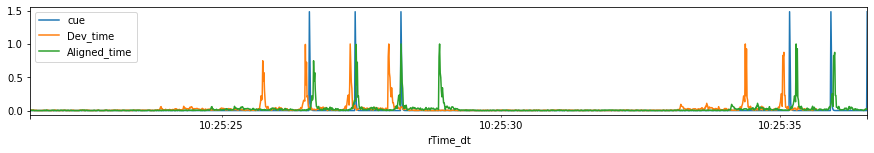

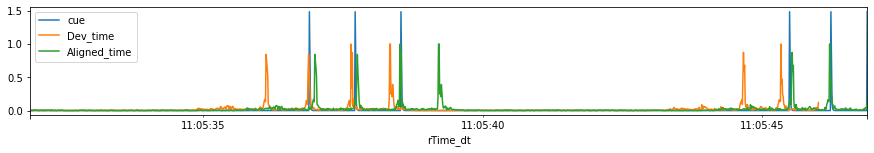

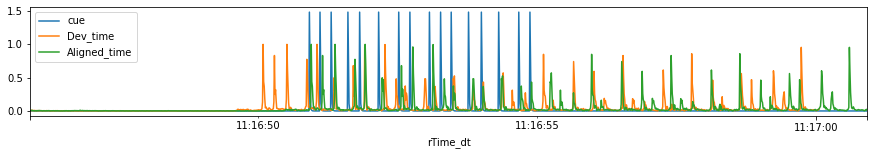

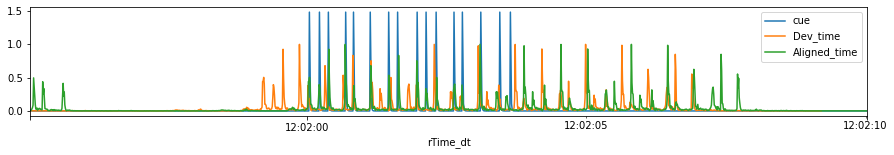

In [16]:
Results = {}
c_type = 'taps'
print(pid)
for c in refs:
    prelim_synch_time = synch_times[c]
    cue = CueT[c].copy()
    cue.loc[:,'dTime'] = pd.to_timedelta(cue['sTime'],unit='s')+prelim_synch_time
    t_range = [cue['sTime'].iloc[0],cue['sTime'].iloc[-1]]
    xrange = [pd.to_timedelta(t_range[0],unit = 's') + prelim_synch_time,pd.to_timedelta(t_range[1],unit = 's') + prelim_synch_time]

    fig,ax = plt.subplots(1,1,figsize=(15,2))
    
    cue.plot.line(x='dTime',y=c_type,label='cue',ax=ax)
    
    X = ACC.loc[ACC['rTime_dt']<xrange[1],:].copy()
    X = X.loc[X['rTime_dt']>=xrange[0],:].copy()
    
    signal = X.loc[:,['dev_dTime','signal','rTime_dt']].copy()
    M = signal['signal'].quantile(0.998)
    signal.loc[:,'signal']  = signal['signal']/M
    signal.loc[signal['signal']>1,'signal'] = 1
    signal.loc[signal['signal']<0,'signal'] = 0
    
    signal.plot(x='dev_dTime',y='signal',label='Dev_time',ax=ax)
    signal.plot(x='rTime_dt',y='signal',label='Aligned_time',ax=ax)
    ax.set_xlim(xrange)
    plt.show()

### Prep Shift variables

In [17]:
cue_time_map = pd.DataFrame(index = cues_aligned.columns,columns = ['dt_UTC','cTime_s','rTime_s'])
cue_time_map['dt_UTC'] = pd.Series(synch_times)
rec_days = {'Re':['RE_Synch', 'RD_Synch', 'RD_Reic','RD_Reic2'], #, 'RD_Reic2'
            'D1':['C1_Synch', 'C1_Reic','C2_Synch', 'C2_Reic'],
           'D2':['C3_Synch', 'C3_Reic', 'C4_Synch', 'C4_Reic'],
            'D3':['C5_Synch', 'C5_Reic']}
sync_days = {'Re':'RE_Synch',
            'D1':'C1_Synch',
            'D2':'C3_Synch',
            'D3':'C5_Synch'}
shows_days = {'Re':['RG','RE','RD'],
            'D1':['C1','C2'],
            'D2':['C3','C4'],
            'D3':['C5']}
rec_con = {'RE':['RE_Synch'],
           'RD':['RD_Synch', 'RD_Reic','RD_Reic2'],#, 'RD_Reic2'
           'C1':['C1_Synch', 'C1_Reic'],
           'C2':['C2_Synch', 'C2_Reic'],
           'C3':['C3_Synch', 'C3_Reic'],
           'C4':[ 'C4_Synch', 'C4_Reic'],
           'C5':['C5_Synch', 'C5_Reic']}
sync_con = {'RG':'RE_Synch',
            'RE':'RE_Synch',
            'RD':'RD_Synch',
            'C1':'C1_Synch',
            'C2':'C2_Synch', 
            'C3':'C3_Synch',
            'C4':'C4_Synch',
            'C5':'C5_Synch'}

for s in rec_days.keys():
    cue_time_map.loc[rec_days[s],'rTime_s'] = (cue_time_map.loc[rec_days[s],'dt_UTC']-cue_time_map.loc[sync_days[s],'dt_UTC']).dt.total_seconds()
for s in rec_con.keys():
    cue_time_map.loc[rec_con[s],'cTime_s'] = (cue_time_map.loc[rec_con[s],'dt_UTC']-cue_time_map.loc[sync_con[s],'dt_UTC']).dt.total_seconds()

#cue_time_map.loc[[],'cTime_s'] = 
cue_time_map.to_csv('./Timing/cue_times_mapping.csv')
cue_time_map

,dt_UTC,cTime_s,rTime_s
RE_Synch,2023-02-15 10:25:26.573000+00:00,0.0,0.0
RD_Synch,2023-02-15 11:05:36.897000+00:00,0.0,2410.324
RD_Reic,2023-02-15 11:16:50.919000+00:00,674.022,3084.346
RD_Reic2,2023-02-15 12:02:00.040000+00:00,3383.143,5793.467
C1_Synch,2023-02-16 08:33:18.524000+00:00,0.0,0.0
C1_Reic,2023-02-16 08:45:22.446000+00:00,723.922,723.922
C2_Synch,2023-02-16 10:16:22.697000+00:00,0.0,6184.173
C2_Reic,2023-02-16 10:27:10.927000+00:00,648.23,6832.403
C3_Synch,2023-02-17 08:30:51.841000+00:00,0.0,0.0
C3_Reic,2023-02-17 08:40:31.007000+00:00,579.166,579.166


In [18]:
#Piece_timings, Piece_dt
Show_intervals = {
    'RG':[pd.to_datetime('2023-02-15 09:00:00.000+0000'),pd.to_datetime('2023-02-15 10:15:00.000+0000')],
    'RE':[pd.to_datetime('2023-02-15 10:13:00.000+0000'),pd.to_datetime('2023-02-15 10:28:00.000+0000')],
    'RD':[pd.to_datetime('2023-02-15 11:05:21.897+0000'),pd.to_datetime('2023-02-15 12:02:27.591+0000')],
    'C1':[pd.to_datetime('2023-02-16 08:33:03.524+0000'),pd.to_datetime('2023-02-16 09:36:09.960+0000')],
    'C2':[pd.to_datetime('2023-02-16 10:16:07.697+0000'),pd.to_datetime('2023-02-16 11:15:33.567+0000')],
    'C3':[pd.to_datetime('2023-02-17 08:30:36.841+0000'),pd.to_datetime('2023-02-17 09:30:11.399+0000')],
    'C4':[pd.to_datetime('2023-02-17 10:16:11.888+0000'),pd.to_datetime('2023-02-17 11:15:14.883+0000')],
    'C5':[pd.to_datetime('2023-02-18 15:10:14.583+0000'),pd.to_datetime('2023-02-18 16:10:47.401+0000')]}
Show_syncs = {
    'RG':pd.to_datetime('2023-02-15 09:00:00.000+0000'),
    'RE':pd.to_datetime('2023-02-15 10:13:00.000+0000'),
    'RD':pd.to_datetime('2023-02-15 11:05:36.897+0000'),
    'C1':pd.to_datetime('2023-02-16 08:33:18.524+0000'),
    'C2':pd.to_datetime('2023-02-16 10:16:22.697+0000'),
    'C3':pd.to_datetime('2023-02-17 08:30:51.841+0000'),
    'C4':pd.to_datetime('2023-02-17 10:16:26.888+0000'),
    'C5':pd.to_datetime('2023-02-18 15:10:29.583+0000')}

In [19]:
NODATE = pd.to_datetime('2023-02-15 25:25:26.573+0000', errors='coerce')

Align_Params = {'PartID':'','Day':'','DevID':'',
             'Cue0_code':'','Cue0_ddt':NODATE,'Cue0_rdt':NODATE,'Cue0_rst':np.nan,'Cue0_shift':np.nan,
             'Cue1_code':'','Cue1_ddt':NODATE,'Cue1_shift':np.nan,
            'Scaling_C':np.nan,'Source_filename':'','Output_files':[]}

# Align and Cut AX3 data

In [35]:
dev_scalings = pd.read_csv('Dev_scaling.csv')
dev_scalings#.loc[dev_scalings['Dev_ID']==int(ap['DevID']),'Scaling_C']

,Dev_ID,PartID,Scaling_C
0,3420426,VN102,1.000129
1,5022006,VN107,1.000082
2,5022002,VN106,1.000074
3,5022009,VN108,1.000080
4,3420415,VN101,1.000130
...,...,...,...
63,14083,VN104,0.999998
64,17515,VN105,1.000003
65,17384,VN106,1.000012
66,14940,VN107,1.000002


In [30]:
Show_folder = {
    'RG':'../Data/AX3/Aligned/20230215_RG/Full/',
    'RE':'../Data/AX3/Aligned/20230215_RE/Full/',
    'RD':'../Data/AX3/Aligned/20230215_RD/Full/',
    'C1':'../Data/AX3/Aligned/20230216_C1/Full/',
    'C2':'../Data/AX3/Aligned/20230216_C2/Full/',
    'C3':'../Data/AX3/Aligned/20230217_C3/Full/',
    'C4':'../Data/AX3/Aligned/20230217_C4/Full/',
    'C5':'../Data/AX3/Aligned/20230218_C5/Full/'}

sig_type = 'AX3ACC'

## Test one

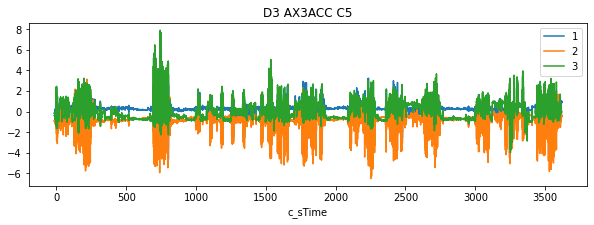

7.486263036727905


In [31]:
tic = time.time()

pid = 'VN102'
rec_day = 'D3'

ap = Align_Params.copy() # missing VN106 D2, minssing VN209 Re,  VN209 half of D1, single LS404 D3
ap['PartID'] = pid 
ap['Day'] =  rec_day
Concert = shows_days[ap['Day']][0] # should be the same for all shows
ap['Source_filename'] = ax3_files.loc[ap['PartID'],Concert]
ap['DevID'] = ax3_files.loc[ap['PartID'],Concert].split('/')[-1].split('_')[0]        # select cues

refs = rec_days[ap['Day']]
#sref = sync_days[ap['Day']]
# for this recording interval and sensor, find the earliest and latest detected cues
G = cues_aligned.loc[ap['PartID'],refs].copy()
subrefs = list(G.loc[~pd.isnull(G)].index)

outfiles = []
if subrefs:
    # figure out realignment parameters for this device and recording interval
    if len(subrefs)==1:
        sref = subrefs[0]
        ap['Cue0_code'] = sref
        ap['Cue0_ddt'] = cues_aligned.loc[ap['PartID'],sref]
        ap['Cue0_rdt'] = cue_time_map.loc[sref,'dt_UTC']
        ap['Cue0_rst'] = cue_time_map.loc[sref,'rTime_s']
        ap['Cue0_shift'] = (cue_time_map.loc[sref,'dt_UTC']-cues_aligned.loc[ap['PartID'],sref]).total_seconds() # shift is the value tot be added to the dev time to get thses emoments aligned.
        ap['Scaling_C'] = dev_scalings.loc[dev_scalings['Dev_ID']==int(ap['DevID']),'Scaling_C'].values[0] #1 # define from average after? or other intervals form that sensor?

    else:
        sref = subrefs[0]
        eref = subrefs[-1]
        if (cue_time_map.loc[eref,'dt_UTC']-cue_time_map.loc[sref,'dt_UTC']).total_seconds()>3600:
            # retain drift_C for stats
            ap['Cue0_code'] = sref
            ap['Cue0_ddt'] = cues_aligned.loc[ap['PartID'],sref]
            ap['Cue0_rdt'] = cue_time_map.loc[sref,'dt_UTC']
            ap['Cue0_rst'] = cue_time_map.loc[sref,'rTime_s']
            ap['Cue0_shift'] = (cue_time_map.loc[sref,'dt_UTC']-cues_aligned.loc[ap['PartID'],sref]).total_seconds() # shift is the value tot be added to the dev time to get thses emoments aligned.
            ap['Cue1_code'] = eref
            ap['Cue1_ddt'] = cues_aligned.loc[ap['PartID'],eref]
            ap['Cue1_shift'] = (cue_time_map.loc[eref,'dt_UTC']-cues_aligned.loc[ap['PartID'],eref]).total_seconds()
            ap['Scaling_C'] = ((cue_time_map.loc[eref,'dt_UTC']-cue_time_map.loc[sref,'dt_UTC']).total_seconds()
                               /(ap['Cue1_ddt']-ap['Cue0_ddt']).total_seconds())
        else:
            sref = subrefs[0]
            ap['Cue0_code'] = sref
            ap['Cue0_ddt'] = cues_aligned.loc[ap['PartID'],sref]
            ap['Cue0_rdt'] = cue_time_map.loc[sref,'dt_UTC']
            ap['Cue0_rst'] = cue_time_map.loc[sref,'rTime_s']
            ap['Cue0_shift'] = (cue_time_map.loc[sref,'dt_UTC']-cues_aligned.loc[ap['PartID'],sref]).total_seconds() # shift is the value tot be added to the dev time to get thses emoments aligned.
            ap['Scaling_C'] = dev_scalings.loc[dev_scalings['Dev_ID']==int(ap['DevID']),'Scaling_C'].values[0] #1 # define from average after? or other intervals form that sensor?

            


    f = ax3_files.loc[ap['PartID'],Concert]

    V = pd.read_csv(f,header = None)
    dt_col = V.columns[0] # assume first column is time, specifically datetime
    sig_col = V.columns[1:]
    V[dt_col]=pd.to_datetime(V[dt_col]).dt.tz_localize('Europe/Oslo').dt.tz_convert('UTC')

    RecTimeSig = pd.DataFrame()
    RecTimeSig['rec_sTime'] = np.round((V[dt_col]-ap['Cue0_ddt']).dt.total_seconds()*ap['Scaling_C'],3)+ap['Cue0_rst']
    RecTimeSig['rec_dTime'] = pd.to_timedelta(RecTimeSig['rec_sTime'] - ap['Cue0_rst'],unit='s') + ap['Cue0_rdt']
    RecTimeSig['dev_dTime'] = V[dt_col]
    RecTimeSig.loc[:,sig_col] = V[sig_col]

    new_col_order=['c_sTime']+list(sig_col) + ['rec_dTime','dev_dTime']

    for ev in shows_days[ap['Day']]:
        cuts = Show_intervals[ev]
        subsig  = al.dt_cut(RecTimeSig,'rec_dTime',cuts[0],cuts[1])
        subsig['c_sTime'] = (subsig['rec_dTime']-Show_syncs[ev]).dt.total_seconds()
        seg_filename = ev + '_FULL_' + ap['PartID'] + '_' + sig_type + '.csv'
        subsig[new_col_order].to_csv(Show_folder[ev] + seg_filename)
        outfiles.append(seg_filename)
        
        subsig.plot(x='c_sTime',y = sig_col,figsize=[10,3])
        plt.title( ap['Day'] + ' ' + sig_type + ' ' + ev )
        plt.show()

        print(time.time() - tic)
    ap['Output_files'] = outfiles
else:
    print('No signal')

## Now Full AX3

In [38]:
ax3_files.index[8:]

Index(['VN104', 'VN105', 'VN106', 'VN107', 'VN108'], dtype='object', name='PartID')

VN104 Re AX3ACC 10.249 10.25
VN104 Re AX3ACC 11.753 11.754
VN104 Re AX3ACC 16.682 16.683
VN104 D1 AX3ACC 7.582 24.266
VN104 D1 AX3ACC 12.655 29.34
VN104 D2 AX3ACC 7.011 36.352
VN104 D2 AX3ACC 12.009 41.35
VN104 D3 AX3ACC 6.675 48.026
VN105 Re AX3ACC 10.098 58.125
VN105 Re AX3ACC 11.665 59.692
VN105 Re AX3ACC 16.707 64.734
VN105 D1 AX3ACC 7.211 71.947
VN105 D1 AX3ACC 11.996 76.732
VN105 D2 AX3ACC 6.569 83.302
VN105 D2 AX3ACC 11.381 88.115
VN105 D3 AX3ACC 6.462 94.578
VN106 Re AX3ACC 9.855 104.434
VN106 Re AX3ACC 11.281 105.86
VN106 Re AX3ACC 16.089 110.668
VN106 D1 AX3ACC 7.073 117.743
VN106 D1 AX3ACC 11.966 122.635
VN106 D2 AX3ACC 7.372 130.008
VN106 D2 AX3ACC 12.384 135.02
VN106 D3 AX3ACC 6.636 141.657
No data VN107 RG
VN107 D1 AX3ACC 7.382 149.041
VN107 D1 AX3ACC 12.52 154.179
VN107 D2 AX3ACC 7.515 161.695
VN107 D2 AX3ACC 12.605 166.784
VN107 D3 AX3ACC 6.74 173.526
VN108 Re AX3ACC 10.556 184.083
VN108 Re AX3ACC 12.111 185.639
VN108 Re AX3ACC 17.32 190.848
VN108 D1 AX3ACC 7.308 198.15

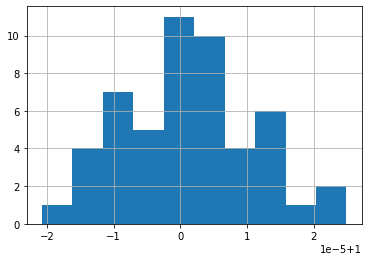

,PartID,Day,DevID,Cue0_code,Cue0_ddt,Cue0_rdt,Cue0_rst,Cue0_shift,Cue1_code,Cue1_ddt,Cue1_shift,Scaling_C,Source_filename,Output_files
0,LS401,Re,14564,RE_Synch,2023-02-15 10:25:25.663000+00:00,2023-02-15 10:25:26.573000+00:00,0.0,0.91,RD_Reic2,2023-02-15 12:01:59.220000+00:00,0.82,0.999984,../Data/AX3/150223/14564_0000001508.csv,"[RG_FULL_LS401_AX3ACC.csv, RE_FULL_LS401_AX3AC..."
1,LS401,D1,14564,C1_Synch,2023-02-16 08:33:21.924000+00:00,2023-02-16 08:33:18.524000+00:00,0.0,-3.4,C2_Reic,2023-02-16 10:27:14.287000+00:00,-3.36,1.000006,../Data/AX3/160223/14564_0000001608.csv,"[C1_FULL_LS401_AX3ACC.csv, C2_FULL_LS401_AX3AC..."
2,LS401,D2,14564,C3_Synch,2023-02-17 08:30:55.911000+00:00,2023-02-17 08:30:51.841000+00:00,0.0,-4.07,C4_Reic,2023-02-17 10:27:24.759000+00:00,-3.99,1.000011,../Data/AX3/170223/14564_0000001708.csv,"[C3_FULL_LS401_AX3ACC.csv, C4_FULL_LS401_AX3AC..."
3,LS401,D3,14564,C5_Synch,2023-02-18 15:10:34.463000+00:00,2023-02-18 15:10:29.583000+00:00,0.0,-4.88,,NaT,NaN,1.000007,../Data/AX3/180223/14564_0000001808.csv,[C5_FULL_LS401_AX3ACC.csv]
4,LS405,Re,17510,RE_Synch,2023-02-15 10:25:25.923000+00:00,2023-02-15 10:25:26.573000+00:00,0.0,0.65,RD_Reic2,2023-02-15 12:01:59.510000+00:00,0.53,0.999979,../Data/AX3/150223/17510_0000001513.csv,"[RG_FULL_LS405_AX3ACC.csv, RE_FULL_LS405_AX3AC..."
5,LS405,D1,17510,C1_Reic,2023-02-16 08:45:25.956000+00:00,2023-02-16 08:45:22.446000+00:00,723.922,-3.51,C2_Reic,2023-02-16 10:27:14.497000+00:00,-3.57,0.99999,../Data/AX3/160223/17510_0000001613.csv,"[C1_FULL_LS405_AX3ACC.csv, C2_FULL_LS405_AX3AC..."
6,LS405,D2,17510,C3_Synch,2023-02-17 08:30:55.941000+00:00,2023-02-17 08:30:51.841000+00:00,0.0,-4.1,C4_Reic,2023-02-17 10:27:24.979000+00:00,-4.21,0.999984,../Data/AX3/170223/17510_0000001713.csv,"[C3_FULL_LS405_AX3ACC.csv, C4_FULL_LS405_AX3AC..."
7,LS405,D3,17510,C5_Synch,2023-02-18 15:10:34.833000+00:00,2023-02-18 15:10:29.583000+00:00,0.0,-5.25,,NaT,NaN,0.99999,../Data/AX3/180223/17510_0000001813.csv,[C5_FULL_LS405_AX3ACC.csv]
8,LS406,Re,14341,RE_Synch,2023-02-15 10:25:25.783000+00:00,2023-02-15 10:25:26.573000+00:00,0.0,0.79,RD_Reic2,2023-02-15 12:01:59.160000+00:00,0.88,1.000016,../Data/AX3/150223/14341_0000001502.csv,"[RG_FULL_LS406_AX3ACC.csv, RE_FULL_LS406_AX3AC..."
9,LS406,D1,14341,C1_Synch,2023-02-16 08:33:21.944000+00:00,2023-02-16 08:33:18.524000+00:00,0.0,-3.42,C2_Reic,2023-02-16 10:27:14.217000+00:00,-3.29,1.000019,../Data/AX3/160223/14341_0000001602.csv,"[C1_FULL_LS406_AX3ACC.csv, C2_FULL_LS406_AX3AC..."


In [39]:
# CUTLOGS = pd.DataFrame(columns = ap.keys())
# cut_ind = 0
toc = time.time()
for pid in ax3_files.index[8:]:
    
    for rec_day in rec_days.keys():
        tic = time.time()
        outfiles = []
        ap = Align_Params.copy() # missing VN106 D2, minssing VN209 Re,  VN209 half of D1, single LS404 D3
        ap['PartID'] = pid 
        ap['Day'] =  rec_day
        Concert = shows_days[ap['Day']][0] # should be the same for all shows
        
        if pd.isnull(ax3_files.loc[ap['PartID'],Concert]):
            print('No data ' + ap['PartID'] + ' ' + Concert)
        else:
            ap['Source_filename'] = ax3_files.loc[ap['PartID'],Concert]
            ap['DevID'] = ax3_files.loc[ap['PartID'],Concert].split('/')[-1].split('_')[0]        # select cues

            refs = rec_days[ap['Day']]
            #sref = sync_days[ap['Day']]
            # for this recording interval and sensor, find the earliest and latest detected cues
            G = cues_aligned.loc[ap['PartID'],refs].copy()
            subrefs = list(G.loc[~pd.isnull(G)].index)
            if subrefs:
                # figure out realignment parameters for this device and recording interval
                if len(subrefs)==1:
                    sref = subrefs[0]
                    ap['Cue0_code'] = sref
                    ap['Cue0_ddt'] = cues_aligned.loc[ap['PartID'],sref]
                    ap['Cue0_rdt'] = cue_time_map.loc[sref,'dt_UTC']
                    ap['Cue0_rst'] = cue_time_map.loc[sref,'rTime_s']
                    ap['Cue0_shift'] = (cue_time_map.loc[sref,'dt_UTC']-cues_aligned.loc[ap['PartID'],sref]).total_seconds() # shift is the value tot be added to the dev time to get thses emoments aligned.
                    ap['Scaling_C'] = dev_scalings.loc[dev_scalings['Dev_ID']==int(ap['DevID']),'Scaling_C'].values[0] #1 # define from average after? or other intervals form that sensor?

                else:
                    sref = subrefs[0]
                    eref = subrefs[-1]
                    if (cue_time_map.loc[eref,'dt_UTC']-cue_time_map.loc[sref,'dt_UTC']).total_seconds()>3600:
                        # retain drift_C for stats
                        ap['Cue0_code'] = sref
                        ap['Cue0_ddt'] = cues_aligned.loc[ap['PartID'],sref]
                        ap['Cue0_rdt'] = cue_time_map.loc[sref,'dt_UTC']
                        ap['Cue0_rst'] = cue_time_map.loc[sref,'rTime_s']
                        ap['Cue0_shift'] = (cue_time_map.loc[sref,'dt_UTC']-cues_aligned.loc[ap['PartID'],sref]).total_seconds() # shift is the value tot be added to the dev time to get thses emoments aligned.
                        ap['Cue1_code'] = eref
                        ap['Cue1_ddt'] = cues_aligned.loc[ap['PartID'],eref]
                        ap['Cue1_shift'] = (cue_time_map.loc[eref,'dt_UTC']-cues_aligned.loc[ap['PartID'],eref]).total_seconds()
                        ap['Scaling_C'] = ((cue_time_map.loc[eref,'dt_UTC']-cue_time_map.loc[sref,'dt_UTC']).total_seconds()
                                           /(ap['Cue1_ddt']-ap['Cue0_ddt']).total_seconds())
                    else:
                        sref = subrefs[0]
                        ap['Cue0_code'] = sref
                        ap['Cue0_ddt'] = cues_aligned.loc[ap['PartID'],sref]
                        ap['Cue0_rdt'] = cue_time_map.loc[sref,'dt_UTC']
                        ap['Cue0_rst'] = cue_time_map.loc[sref,'rTime_s']
                        ap['Cue0_shift'] = (cue_time_map.loc[sref,'dt_UTC']-cues_aligned.loc[ap['PartID'],sref]).total_seconds() # shift is the value tot be added to the dev time to get thses emoments aligned.
                        ap['Scaling_C'] = dev_scalings.loc[dev_scalings['Dev_ID']==int(ap['DevID']),'Scaling_C'].values[0] #1 # define from average after? or other intervals form that sensor?

                f = ax3_files.loc[ap['PartID'],Concert]

                V = pd.read_csv(f,header = None)
                dt_col = V.columns[0] # assume first column is time, specifically datetime
                sig_col = V.columns[1:]
                V[dt_col]=pd.to_datetime(V[dt_col]).dt.tz_localize('Europe/Oslo').dt.tz_convert('UTC')

                RecTimeSig = pd.DataFrame()
                RecTimeSig['rec_sTime'] = np.round((V[dt_col]-ap['Cue0_ddt']).dt.total_seconds()*ap['Scaling_C'],3)+ap['Cue0_rst']
                RecTimeSig['rec_dTime'] = pd.to_timedelta(RecTimeSig['rec_sTime'] - ap['Cue0_rst'],unit='s') + ap['Cue0_rdt']
                RecTimeSig['dev_dTime'] = V[dt_col]
                RecTimeSig.loc[:,sig_col] = V[sig_col]

                new_col_order=['c_sTime']+list(sig_col) + ['rec_dTime','dev_dTime']

                for ev in shows_days[ap['Day']]:
                    cuts = Show_intervals[ev]
                    subsig  = al.dt_cut(RecTimeSig,'rec_dTime',cuts[0],cuts[1])
                    subsig['c_sTime'] = (subsig['rec_dTime']-Show_syncs[ev]).dt.total_seconds()
                    seg_filename = ev + '_FULL_' + ap['PartID'] + '_' + sig_type + '.csv'
                    subsig[new_col_order].to_csv(Show_folder[ev] + seg_filename)
                    outfiles.append(seg_filename)
                    print(' '.join([ap['PartID'],ap['Day'],sig_type,str(np.round(time.time() - tic,3)),str(np.round(time.time() - toc,3))]))

                ap['Output_files'] = outfiles
                CUTLOGS.loc[cut_ind,:] = ap # it's growing slowly, chill pandas
                cut_ind += 1
            else:
                print('No synch info for ' +ap['PartID'] + ' ' + ap['Day'])

CUTLOGS.to_csv('./out_data/AX3_CUTLOGS.csv')
CUTLOGS['Scaling_C'].hist()
plt.show()
CUTLOGS

In [40]:
CUTLOGS[['PartID','Day','DevID','Scaling_C','Cue0_code','Cue1_code']]

,PartID,Day,DevID,Scaling_C,Cue0_code,Cue1_code
0,LS401,Re,14564,0.999984,RE_Synch,RD_Reic2
1,LS401,D1,14564,1.000006,C1_Synch,C2_Reic
2,LS401,D2,14564,1.000011,C3_Synch,C4_Reic
3,LS401,D3,14564,1.000007,C5_Synch,
4,LS405,Re,17510,0.999979,RE_Synch,RD_Reic2
5,LS405,D1,17510,0.99999,C1_Reic,C2_Reic
6,LS405,D2,17510,0.999984,C3_Synch,C4_Reic
7,LS405,D3,17510,0.99999,C5_Synch,
8,LS406,Re,14341,1.000016,RE_Synch,RD_Reic2
9,LS406,D1,14341,1.000019,C1_Synch,C2_Reic


# Testing plots

In [ ]:
Piece_timings.loc[20:34,]

In [45]:
ev = 'C4'
data_loc = '../Data/AX3/Aligned/20230217_C4/Full/'

files = os.listdir(data_loc)
files.sort()
files
# signal File type and column name (multi sample)
sf = 100 # hz 
s_time = Piece_timings.loc[3,ev]
s_dtime = Piece_dt.loc[3,ev]
e_time =  Piece_timings.loc[33,ev]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
time_dt = s_dtime + pd.to_timedelta(time_s,unit='s')

In [51]:
ev = 'C5'
data_loc = '../Data/AX3/Aligned/20230218_C5/Full/'

files = os.listdir(data_loc)
files.sort()
files
# signal File type and column name (multi sample)
sf = 100 # hz 
s_time = Piece_timings.loc[3,ev]
s_dtime = Piece_dt.loc[3,ev]
e_time =  Piece_timings.loc[33,ev]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
time_dt = s_dtime + pd.to_timedelta(time_s,unit='s')

In [52]:
df_sig = pd.DataFrame(index = time_s) # Piece_timings.loc[2,ev]
# ACC
for f in files: #['c_sTime']
    PartName = f.split('_')[2]
    sigName = f.split('_')[3].split('.')[0]
    V = pd.read_csv(data_loc+f,skipinitialspace=True,index_col=0)
    sig_t = V['c_sTime']
    cols = V.columns
    sig_v = np.sqrt(np.square(V[['1','2','3']].diff()).sum(axis=1))
    f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
    new_sig = f(time_s)
     #   if pd.Series(new_sig).diff().abs().sum()/len(new_sig)>1: # since th
    df_sig.loc[:,PartName] = new_sig

In [53]:
t1 = Piece_timings.loc[31,ev]
t2 = Piece_timings.loc[31,ev] + 30
# t1 = 216.17
# t2 = 246.17
interval_name = 'Full'
sub_sig = df_sig.loc[t1:t2,:].copy()
sub_sig.fillna(sub_sig.mean().mean(),inplace = True)

The alignment is worse for C5 than for C4, meaning that the median deviance on a given device is not so reliable. There is variation from day to day it seems. 

However, this alignment still improves upon the results without shift correction, or without any scaling

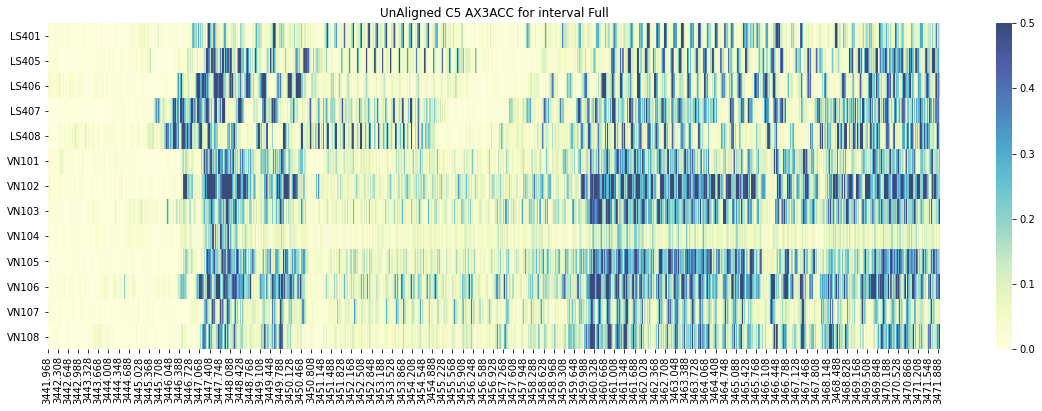

In [64]:
fig, (ax1) = plt.subplots(1, 1,figsize = [20,6])
chart = sns.heatmap(data=sub_sig.transpose(), ax=ax1,vmin=0, vmax=0.5, cbar=True,cmap="YlGnBu",alpha=0.8)

# chart = sns.heatmap(data=df_sig.transpose(), ax=ax1,vmin=40, vmax=120, cbar=True, cmap="YlGnBu",alpha=0.8)
#ax1.set_yticks([])
plt.title('UnAligned '+ev + ' ' + sigName + ' for interval ' + interval_name)
#plt.savefig('./plots/'+projectName+'_'+ interval_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

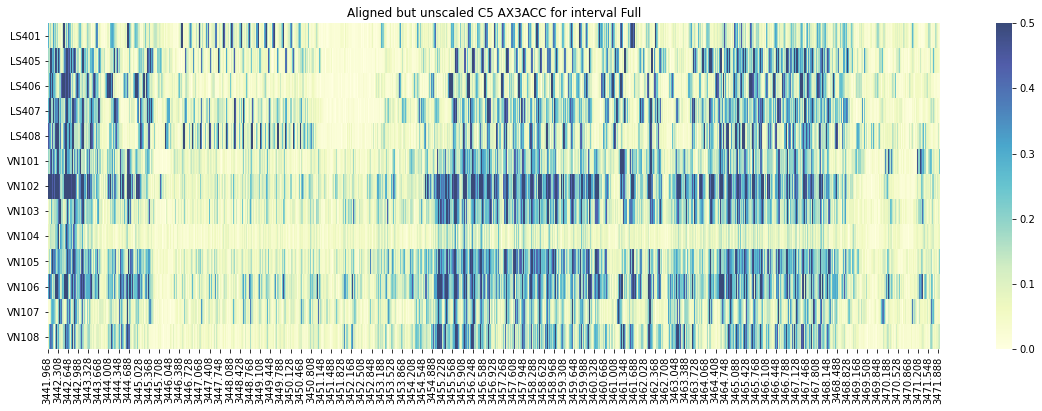

In [68]:
fig, (ax1) = plt.subplots(1, 1,figsize = [20,6])
chart = sns.heatmap(data=sub_sig.transpose(), ax=ax1,vmin=0, vmax=0.5, cbar=True,cmap="YlGnBu",alpha=0.8)

# chart = sns.heatmap(data=df_sig.transpose(), ax=ax1,vmin=40, vmax=120, cbar=True, cmap="YlGnBu",alpha=0.8)
#ax1.set_yticks([])
plt.title('Aligned but unscaled '+ev + ' ' + sigName + ' for interval ' + interval_name)
#plt.savefig('./plots/'+projectName+'_'+ interval_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

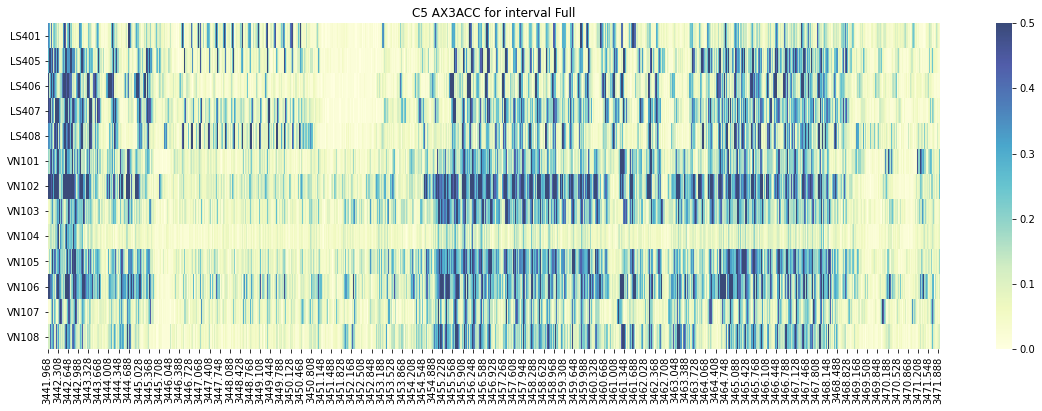

In [54]:
fig, (ax1) = plt.subplots(1, 1,figsize = [20,6])
chart = sns.heatmap(data=sub_sig.transpose(), ax=ax1,vmin=0, vmax=0.5, cbar=True,cmap="YlGnBu",alpha=0.8)

# chart = sns.heatmap(data=df_sig.transpose(), ax=ax1,vmin=40, vmax=120, cbar=True, cmap="YlGnBu",alpha=0.8)
#ax1.set_yticks([])
plt.title(ev + ' ' + sigName + ' for interval ' + interval_name)
#plt.savefig('./plots/'+projectName+'_'+ interval_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

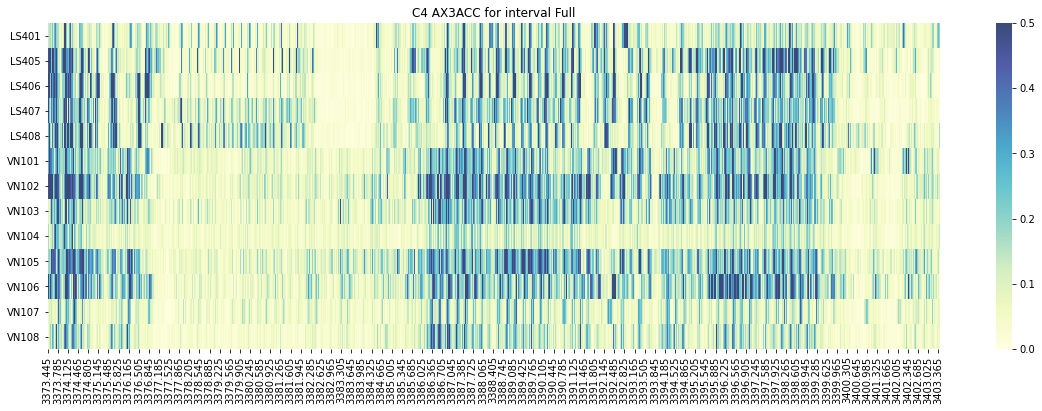

In [50]:
fig, (ax1) = plt.subplots(1, 1,figsize = [20,6])
chart = sns.heatmap(data=sub_sig.transpose(), ax=ax1,vmin=0, vmax=0.5, cbar=True,cmap="YlGnBu",alpha=0.8)

# chart = sns.heatmap(data=df_sig.transpose(), ax=ax1,vmin=40, vmax=120, cbar=True, cmap="YlGnBu",alpha=0.8)
#ax1.set_yticks([])
plt.title(ev + ' ' + sigName + ' for interval ' + interval_name)
#plt.savefig('./plots/'+projectName+'_'+ interval_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

In [62]:
df_sig = pd.DataFrame(index = time_s) # Piece_timings.loc[2,ev]
# ACC
for f in files: #['c_sTime']
    PartName = f.split('_')[2]
    sigName = f.split('_')[3].split('.')[0]
    V = pd.read_csv(data_loc+f,skipinitialspace=True,index_col=0)
    sig_t = (pd.to_datetime(V['dev_dTime'])-cue_time_map.loc['C5_Synch','dt_UTC']).dt.total_seconds() #V['c_sTime']
    cols = V.columns
    sig_v = np.sqrt(np.square(V[['1','2','3']].diff()).sum(axis=1))
    f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
    new_sig = f(time_s)
     #   if pd.Series(new_sig).diff().abs().sum()/len(new_sig)>1: # since th
    df_sig.loc[:,PartName] = new_sig

In [66]:
df_sig = pd.DataFrame(index = time_s) # Piece_timings.loc[2,ev]
# ACC
for f in files: #['c_sTime']
    PartName = f.split('_')[2]
    sigName = f.split('_')[3].split('.')[0]
    V = pd.read_csv(data_loc+f,skipinitialspace=True,index_col=0)
    sig_t = (pd.to_datetime(V['dev_dTime'])-cues_aligned.loc[PartName,'C5_Synch']).dt.total_seconds()#(pd.to_datetime(V['dev_dTime'])-cue_time_map.loc['C5_Synch','dt_UTC']).dt.total_seconds() #V['c_sTime']
    cols = V.columns
    sig_v = np.sqrt(np.square(V[['1','2','3']].diff()).sum(axis=1))
    f = interpolate.interp1d(sig_t, sig_v,fill_value='extrapolate')
    new_sig = f(time_s)
     #   if pd.Series(new_sig).diff().abs().sum()/len(new_sig)>1: # since th
    df_sig.loc[:,PartName] = new_sig

In [67]:
t1 = Piece_timings.loc[31,ev]
t2 = Piece_timings.loc[31,ev] + 30
# t1 = 216.17
# t2 = 246.17
interval_name = 'Full'
sub_sig = df_sig.loc[t1:t2,:].copy()
sub_sig.fillna(sub_sig.mean().mean(),inplace = True)

In [65]:
(pd.to_datetime(V['dev_dTime'])-cues_aligned.loc[PartName,'C5_Synch']).dt.total_seconds()

669382      -14.997
669383      -14.987
669384      -14.977
669385      -14.968
669386      -14.958
             ...   
1037529    3617.755
1037530    3617.765
1037531    3617.775
1037532    3617.784
1037533    3617.794
Name: dev_dTime, Length: 368152, dtype: float64